# Parte 2 - Tarefa de Classificação

Import das bibliotecas utilizadas:

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix
from sklearn.svm import SVC
#import seaborn as sns
import pandas as pd
import umap.umap_ as umap


## Análise dos dados

Primeiramente é necessário carregar o dataset e analisar o formato dos dados:

In [45]:
digits = datasets.load_digits()
#digits.images são os dados, onde cada sample é uma matriz 8x8 de escalas de cinza
print(digits.images.shape)
print(digits.images[200:205])
#digits.target são as respectivas classes, sendo que essas classes podem ser números de 0 a 9
print(digits.target[200:205])

(1797, 8, 8)
[[[ 0.  0.  0.  0. 11. 12.  0.  0.]
  [ 0.  0.  0.  3. 15. 14.  0.  0.]
  [ 0.  0.  0. 11. 16. 11.  0.  0.]
  [ 0.  0.  9. 16. 16. 10.  0.  0.]
  [ 0.  4. 16. 12. 16. 12.  0.  0.]
  [ 0.  3. 10.  3. 16. 11.  0.  0.]
  [ 0.  0.  0.  0. 16. 14.  0.  0.]
  [ 0.  0.  0.  0. 11. 11.  0.  0.]]

 [[ 0.  2. 16. 16. 16. 14.  5.  0.]
  [ 0.  9. 16. 11.  6.  8.  3.  0.]
  [ 0.  9. 16.  2.  0.  0.  0.  0.]
  [ 0.  3. 16. 13.  1.  0.  0.  0.]
  [ 0.  0.  8. 16. 12.  0.  0.  0.]
  [ 0.  0.  0. 12. 16.  4.  0.  0.]
  [ 0.  0.  1. 11. 16.  6.  0.  0.]
  [ 0.  4. 16. 16.  8.  0.  0.  0.]]

 [[ 0.  0.  4. 15. 11.  1.  0.  0.]
  [ 0.  2. 14. 14. 16.  8.  0.  0.]
  [ 0.  8. 15.  2.  3. 13.  0.  0.]
  [ 0.  4. 16.  0.  0. 12.  7.  0.]
  [ 0.  7. 16.  0.  0. 12.  8.  0.]
  [ 0.  3. 16.  6.  1. 14.  9.  0.]
  [ 0.  0. 15. 16. 16. 16.  2.  0.]
  [ 0.  0.  4. 13. 14.  6.  0.  0.]]

 [[ 0.  0. 10. 15.  7.  0.  0.  0.]
  [ 0.  4. 16. 13. 11. 11.  0.  0.]
  [ 0. 10. 16. 12. 15. 16.  4.  0.]
  [ 0.  3

Também é possível visualizar em forma de imagens.

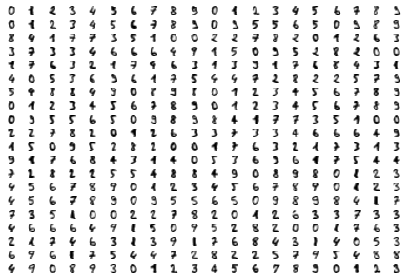

In [46]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

Para aplicar os algoritmos de classificação os samples devem ser vetores e não matrizes, portanto deve-se transformar cada sample do dataset em um vetor de 64 features. Além disso, percebe-se também que há 1797 samples no dataset.

In [47]:
n_samples = len(digits.images)
targets = digits.target
data = digits.images.reshape((n_samples,64))

Vamos visualizar graficamente os dados utilizando UMAP, que é um algoritmo de redução de dimensionalidade.

In [48]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)
embedding.shape

(1797, 2)

Text(0.5, 1.0, 'UMAP projection of standardized data')

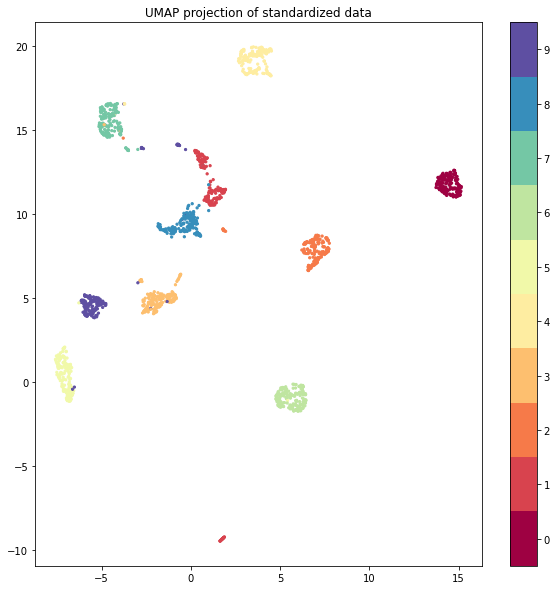

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0],embedding[:,1],c=targets,cmap = 'Spectral',s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of standardized data')

Percebe-se então que o UMAP conseguiu separar bem as classes ao reduzir para somente 2 features. Porém, percebe-se também que alguns samples distoam um pouco dos clusters ao qual eles pertencem, principalmente o número 9, o que deve acontecer provavelmente por conta da baixa qualidade das imagens. Sabendo-se disso, espera-se então que não será possível treinar um modelo perfeito, o que é normal, mas foi enfatizado ao perceber-se que os dados em si já não são perfeitos, o que também é normal.

Além disso, também é possível notar que o número de samples de cada classe parece balanceado, porém é interessante plotar um gráfico para melhor visualização dessa informação, pois o balanceamento dos dados pode influenciar o tipo de métodos e métricas que serão utilizadas.



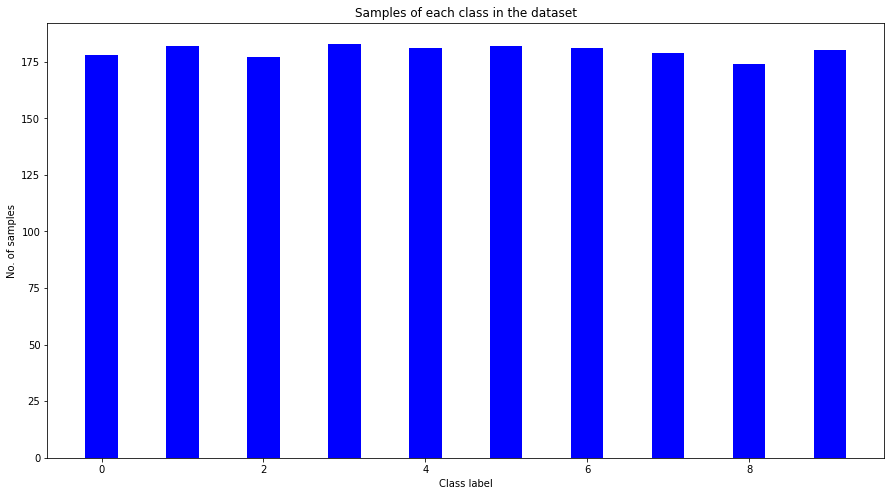

In [50]:
class_count = Counter(targets)
fig = plt.figure(figsize=(15,8))
plt.bar(list(class_count.keys()),list(class_count.values()), color = 'blue', width = 0.4)
plt.xlabel("Class label")
plt.ylabel("No. of samples")
plt.title("Samples of each class in the dataset")
plt.show()


Nota-se, então, que o dataset está balanceado.

Deve-se, então, separar entre set de treino e de teste (90/10):

In [51]:
train_data, test_data, train_targets, test_targets = train_test_split(data,targets,test_size = 0.1)

Apesar das escalas da features não serem muito diferentes entre si, ainda é bom padronizar os dados para garantir a convergência dos algoritmos.

In [52]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

## Logistic Regression

Será utilizado o LogisticRegression do ScikitLearn, que implementa uma regressão logística utilizando os otimizadores newton-cg, sag ou lbfgs, que suportam regularização L2, ou o otimizador liblinear, que suporta regularização L1 e L2. A intensidade da regularização é especificada através do parâmetro C, onde valores pequenos indicam uma regularização forte, enquanto que valores altos indicam uma baixa regularização, assim como o λ visto em aula.

Para usar Cross Validation, será utilizada a função cross_validate do ScikitLearn, onde é implementado um KFold cujo número de folds padrão é 5 mas pode ser alterado através do parâmetro cv, além disso, ela também permite especificar multiplas métricas de avaliação. Para cada métrica é retornado um vetor de floats que contém o valor da respectiva métrica para cada fold, neste trabalho será feita a média aritmética destes valores para avaliar o resultado de cada modelo, juntamente com o tempo médio de fit.

Será avaliada a métrica F1-score pois ela engloba as métricas recall e precision, além de que, por conta do dataset estar balanceado, espera-se que o F1-score seja aproximadamente igual à acurácia.

Os hiperparâmetros que serão testados será o número de folds da CrossValidation (parâmetro cv), a intensidade da regularização (parâmetro C) e o otimizador utilizado, definido pelo parâmetro solver e que também define se o problema utilizará uma função de custo multinomial ou será usado um esquema "one-versus-rest", já que o solver 'liblinear', por exemplo, só suporta este tipo de esquema.

O primeiro modelo a ser treinado terá os hiperparâmetros padrão da biblioteca: KFold de 5 folds, regularização com C=1, algoritmo de otimização lbfgs, função de custo multiclasse escolhida automaticamente por conta dos dados não serem binários e o otimizador suportar esse tipo de função de custo (definido pelo parâmetro multi_class default ser 'auto').

In [53]:
#Modelo default
# Como o dataset é balanceado, então calcular o f1_score para cada classe e então fazer uma média simples
# é o suficiente, por isso f1_score macro
LR_default = LogisticRegression(max_iter=200)
LR_default_results = cross_validate(LR_default,train_data_scaled,train_targets,scoring='f1_macro')
LR_default_f1 = LR_default_results['test_score'].mean()
LR_default_fit_time = LR_default_results['fit_time'].mean()

Ao tentar treinar o modelo com o valor padrão de max_iter o algoritmo não convergiu e, portanto, o número máximo de iterações foi ajustado para 200. Além disso, na mesma mensagem de erro foi sugerido que a falha na convergência pode ter sido por conta dos dados não estarem regularizados, o que mostra a importância do pré processamento que foi feito.

In [54]:
#List contendo as métricas para cada modelo
evaluation_list = []
models_name = []
evaluation_list.append([LR_default_f1,LR_default_fit_time])
models_name.append("Default LinearRegression")

In [55]:
#Modelo com 10-fold
LR_10fold = LogisticRegression(max_iter=200)
LR_10fold_results = cross_validate(LR_10fold,train_data_scaled,train_targets,cv=10,scoring='f1_macro')

LR_10fold_f1 = LR_10fold_results['test_score'].mean()
LR_10fold_fit_time = LR_10fold_results['fit_time'].mean()
evaluation_list.append([LR_10fold_f1,LR_10fold_fit_time])
models_name.append("10-fold LinearRegression")

In [56]:
#Modelo com 2-fold
LR_2fold = LogisticRegression(max_iter=200)
LR_2fold_results = cross_validate(LR_2fold,train_data_scaled,train_targets,cv=2,scoring='f1_macro')

LR_2fold_f1 = LR_2fold_results['test_score'].mean()
LR_2fold_fit_time = LR_2fold_results['fit_time'].mean()
evaluation_list.append([LR_2fold_f1,LR_2fold_fit_time])
models_name.append("2-fold LinearRegression")

In [57]:
#Logistic Regression com regularização fraca ao setar o parâmetro Cs (equivalente ao lambda visto em aula) para um 
#valor alto
LR_no_reg = LogisticRegression(max_iter=200, C = 1000)
LR_no_reg_results = cross_validate(LR_no_reg,train_data_scaled,train_targets,scoring='f1_macro')

LR_no_reg_f1 = LR_no_reg_results['test_score'].mean()
LR_no_reg_fit_time = LR_no_reg_results['fit_time'].mean()
evaluation_list.append([LR_no_reg_f1,LR_no_reg_fit_time])
models_name.append("LinearRegression with weak regularization")

In [58]:
#Logistic Regression com alta regularização ao setar o parâmetro Cs (equivalente ao lambda visto em aula) para um 
#valor baixo
LR_high_reg = LogisticRegression(max_iter=200, C = 0.1)
LR_high_reg_results = cross_validate(LR_high_reg,train_data_scaled,train_targets,scoring='f1_macro')

LR_high_reg_f1 = LR_high_reg_results['test_score'].mean()
LR_high_reg_fit_time = LR_high_reg_results['fit_time'].mean()
evaluation_list.append([LR_high_reg_f1,LR_high_reg_fit_time])
models_name.append("LinearRegression with strong regularization")

In [59]:
#solver liblinear, que realiza uma classificação one-versus-rest
LR_liblinear = LogisticRegression(max_iter=200, solver = 'liblinear')
LR_liblinear_results = cross_validate(LR_liblinear,train_data_scaled,train_targets,scoring='f1_macro')

LR_liblinear_f1 = LR_liblinear_results['test_score'].mean()
LR_liblinear_time = LR_liblinear_results['fit_time'].mean()
evaluation_list.append([LR_liblinear_f1,LR_liblinear_time])
models_name.append("LinearRegression with liblinear solver")

Vamos analisar como cada modelo se comportou.

In [60]:
LR_eval_table = pd.DataFrame(evaluation_list,columns = ['F1-score','fit time'])
LR_eval_table.index = models_name
LR_eval_table

,F1-score,fit time
Default LinearRegression,0.969275,0.103999
10-fold LinearRegression,0.970424,0.113616
2-fold LinearRegression,0.967234,0.075277
LinearRegression with weak regularization,0.953103,0.152412
LinearRegression with strong regularization,0.963110,0.061223
LinearRegression with liblinear solver,0.957178,0.149674


Percebe-se que todos os modelos obtiveram um F1-score médio maior do que 0.95 e o tempo para fazer o fit não chegou a 0.2 segundos para nenhum dos modelos, o que é um bom resultado. O fato de que a mudança, relativamente drástica em alguns casos, dos hiperparâmetros não terem afetado fortemente os resultados provavelmente é por conta do dataset não ser muito volumoso, além de que não há um número enorme de features.

Entretanto, percebe-se que o modelo com 10-fold se destacou dentre os demais, o que faz sentido pois como o set foi dividido em número maior de partes, então há um maior número de dados disponível para treino. Porém, em contrapartida, também há menos dados sendo utilizados para teste, fazendo com que o f1-score obtido não necessariamente seja reflexo de uma boa generalização. Para garantir que um KFold tenha um bom desempenho e seus resultados reflitam a real capacidade de generalização do modelo, o número de folds deve ser ajustado de acordo com o número de dados disponíveis, o que provavelmente não foi o caso.

Além disso, também nota-se que o modelo com regularização fraca obteve o pior resultado dentre os demais. Uma vez que a regularização é baixa, isso provavelmente aconteceu por conta de ter sido aprendida, utilizando os dados de treino, uma função de classificação simples demais, não tendo uma boa generalização e consequentemente classificando erroneamente com mais frequência os dados de teste.

Também é interessante notar que a classificação com esquema one-vs-rest também obteve um bom resultado, o que mostra o porquê esquemas deste tipo são amplamente utilizados apesar de classificações com funções de custo multinomiais parecerem mais "gerais".

## Support Vector Machine

Como segundo método de classificação serão treinadas SVMs. Será utilizada a SVC do ScikitLearn, que é uma C-Support Vector Classification. Por se tratar de uma SVM, então a classificação multiclasse é feita utilizando um esquema one-vs-one.

Assim como na Linear Regression, a intensidade da regularização do modelo é definida pelo parâmetro C. Além disso, outros hiperparâmetros podem ser escolhidos, como o tipo do kernel a ser utilizado e os parâmetros de cada respectivo tipo.

Os hiperparâmetros que serão testados será o número de folds da CrossValidation (parâmetro cv), a intensidade da regularização (parâmetro C) e o tipo de kernel a ser utilizado, definido pelo parâmetro kernel.

O modelo padrão faz um 5-fold, possui C=1 e o kernel é do tipo rbf.

In [61]:
#Modelo default
SVM_default = SVC()
SVM_default_results = cross_validate(SVM_default,train_data_scaled,train_targets,scoring='f1_macro')

SVM_default_f1 = SVM_default_results['test_score'].mean()
SVM_default_time = SVM_default_results['fit_time'].mean()
evaluation_list.append([SVM_default_f1,SVM_default_time])
models_name.append("Default SVM")

In [62]:
#Modelo com 10-fold
SVM_10fold = SVC()
SVM_10fold_results = cross_validate(SVM_10fold,train_data_scaled,train_targets,cv = 10,scoring='f1_macro')

SVM_10fold_f1 = SVM_10fold_results['test_score'].mean()
SVM_10fold_time = SVM_10fold_results['fit_time'].mean()
evaluation_list.append([SVM_10fold_f1,SVM_10fold_time])
models_name.append("10-fold SVM")

In [63]:
#Modelo com 2-fold
SVM_2fold = SVC()
SVM_2fold_results = cross_validate(SVM_2fold,train_data_scaled,train_targets,cv = 2,scoring='f1_macro')

SVM_2fold_f1 = SVM_2fold_results['test_score'].mean()
SVM_2fold_time = SVM_2fold_results['fit_time'].mean()
evaluation_list.append([SVM_2fold_f1,SVM_2fold_time])
models_name.append("2-fold SVM")

In [64]:
#SVM com regularização fraca ao setar o parâmetro Cs (equivalente ao lambda visto em aula) para um 
#valor alto
SVM_no_reg = SVC(C = 1000)
SVM_no_reg_results = cross_validate(SVM_no_reg,train_data_scaled,train_targets,scoring='f1_macro')

SVM_no_reg_f1 = SVM_no_reg_results['test_score'].mean()
SVM_no_reg_time = SVM_no_reg_results['fit_time'].mean()
evaluation_list.append([SVM_no_reg_f1,SVM_no_reg_time])
models_name.append("SVM with weak regularization")

In [65]:
#SVM com alta regularização ao setar o parâmetro Cs (equivalente ao lambda visto em aula) para um 
#valor baixo
SVM_high_reg = SVC(C = 0.1)
SVM_high_reg_results = cross_validate(SVM_high_reg,train_data_scaled,train_targets,scoring='f1_macro')

SVM_high_reg_f1 = SVM_high_reg_results['test_score'].mean()
SVM_high_reg_time = SVM_high_reg_results['fit_time'].mean()
evaluation_list.append([SVM_high_reg_f1,SVM_high_reg_time])
models_name.append("SVM with strong regularization")

In [66]:
#Modelo com kernel = 'linear'
SVM_linear = SVC(kernel = 'linear')
SVM_linear_results = cross_validate(SVM_linear,train_data_scaled,train_targets,scoring='f1_macro')

SVM_linear_f1 = SVM_linear_results['test_score'].mean()
SVM_linear_time = SVM_linear_results['fit_time'].mean()
evaluation_list.append([SVM_linear_f1,SVM_linear_time])
models_name.append("SVM with linear kernel")

Vamos analisar como cada modelo se comportou:

In [67]:
SVM_eval_table = pd.DataFrame(evaluation_list[6:],columns = ['F1-score','fit time'])
SVM_eval_table.index = models_name[6:]
SVM_eval_table

,F1-score,fit time
Default SVM,0.978374,0.049474
10-fold SVM,0.980307,0.057726
2-fold SVM,0.974184,0.027302
SVM with weak regularization,0.977774,0.047667
SVM with strong regularization,0.935066,0.085594
SVM with linear kernel,0.973164,0.022621


Percebe-se que esta abordagem se comportou, no geral, melhor do que os modelos de regressão linear, tanto em questão de f1-score quanto em questão de fit time, com a única exceção sendo a SVM com regularização forte, que teve o pior resultado dentre todos os modelos. 

Também, o modelo 10-fold, assim como na regressão linear, obteve o melhor resultado dentre os demais, provavelmente por conta dos mesmos motivos.

Porém, no caso da SVM o modelo com regularização fraca foi o que mostrou um melhor desempenho enquanto que o com regularização forte teve o pior desempenho, o que indica que a SVM se beneficia mais de modelos mais simplistas.

## Melhor método

Tabela contendo todos os modelos treinados:

In [68]:
eval_table = pd.DataFrame(evaluation_list,columns = ['F1-score','fit time'])
eval_table.index = models_name
eval_table

,F1-score,fit time
Default LinearRegression,0.969275,0.103999
10-fold LinearRegression,0.970424,0.113616
2-fold LinearRegression,0.967234,0.075277
LinearRegression with weak regularization,0.953103,0.152412
LinearRegression with strong regularization,0.963110,0.061223
LinearRegression with liblinear solver,0.957178,0.149674
Default SVM,0.978374,0.049474
10-fold SVM,0.980307,0.057726
2-fold SVM,0.974184,0.027302
SVM with weak regularization,0.977774,0.047667


Através dessa tabela e as análises feitas anteriormente, percebe-se que o melhor modelo obtido foi a SVM com uma cross validation 10-fold.

Como esse foi o modelo com o melhor resultado na média e foi feito um KFold, então agora é necessário encontrar o melhor modelo dentre os que foram treinados durante a Cross Validation, isso é possível ao setar o parâmetro return_estimator da função cross_validate como True, fazendo com que essa função retorne uma lista com todos os modelos treinados durante o processo, e então usá-lo no conjunto de teste.

In [69]:
#Será treinado um outro conjunto de modelos com os mesmo hiper parâmetros usados anteriormente,
# mas com o hiper parâmetro return_estimator como true.
SVM_10fold_final = SVC()
SVM_10fold_final_results = cross_validate(SVM_10fold,train_data_scaled,train_targets,cv = 10,scoring='f1_macro', return_estimator=True)
SVM_10fold_final_results

{'fit_time': array([0.07148194, 0.05968761, 0.05804372, 0.05747271, 0.05750728,
        0.06823397, 0.05741239, 0.05527186, 0.05495644, 0.06199503]),
 'score_time': array([0.01128674, 0.00982141, 0.00939512, 0.00949883, 0.01013637,
        0.01189041, 0.01036835, 0.00989509, 0.01197672, 0.01021695]),
 'estimator': [SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC(),
  SVC()],
 'test_score': array([0.96924682, 0.96938321, 0.9635099 , 0.98114047, 0.98805195,
        1.        , 0.98124389, 0.98118978, 0.98786154, 0.98143939])}

Percebe-se então que o modelo com melhor desempenho foi o segundo, com um f1_score de 0,9935. Ele será, então, utilizado no conjunto de teste.

In [70]:
SVM_best_model = SVM_10fold_final_results['estimator'][1]
test_set_pred = SVM_best_model.predict(test_data_scaled)
test_set_f1_score = f1_score(test_targets,test_set_pred, average='macro')
test_set_f1_score

0.9800688546771583

Apesar do f1-score obtido no conjunto de teste ter sido muito bom, ele não foi tão alto quanto o obtido no conjunto de validação, isso provavelmente aconteceu pelo motivo discutido anteriormente: o 10-fold utilizou muitos dados para treino e, por conta disso, não houve muitos dados no conjunto de validação para testar a real capacidade de generalização do modelo.

Vamos plotar a matriz de confusão para visualizar qual a distribuição das classificações erradas. Primeiro é interessante ver quantos samples de cada classe há neste conjunto.

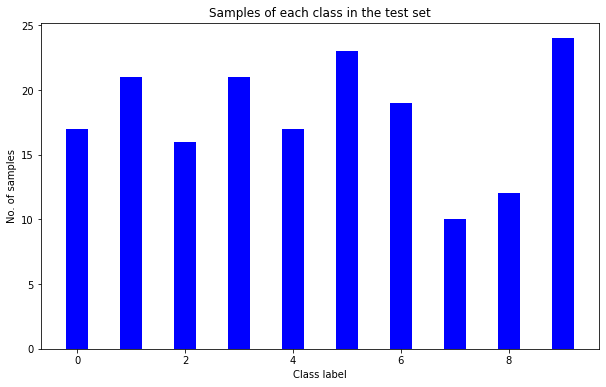

In [71]:
class_count_test = Counter(test_targets)
fig = plt.figure(figsize=(10,6))
plt.bar(list(class_count_test.keys()),list(class_count_test.values()), color = 'blue', width = 0.4)
plt.xlabel("Class label")
plt.ylabel("No. of samples")
plt.title("Samples of each class in the test set")
plt.show()

Como este conjunto não está balanceado então a matriz de confusão não terá as mesmas cores para todas as classes, fazendo com que seja necessário se atentar aos números em si.

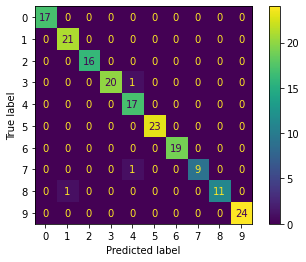

In [72]:
plot_confusion_matrix(SVM_best_model,test_data_scaled,test_targets)

Nota-se que as classes que foram classificadas erroneamente foram somente os números 4,5 e 7, que foram classificados como sendo o número 9. Estas classificações erradas provavelmente foram devido a erros no dataset em si, que não estava com uma qualidade perfeita, é possível deduzir isso pois no gráfico scatter plotado anteriormente com u-map, havia números 9 agrupados nos grupos dos números 4,5 e 7，o que mostra como um bom entendimento dos dados que estão sendo utilizados para treino é importante.